CNS2025 Homework 11

ML and Bayesian decoding for an 11-cell Gaussian population.

In [1]:
# @title
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# @title
# parameters and spike counts
s_pref = np.arange(-5, 6, 1)
sigma_tuning = 1.0
r_max = 10.0

rec1 = np.array([0, 0, 0, 0, 0, 1, 2, 1, 3, 1, 0])
rec2 = np.array([0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 0])
rec3 = np.array([0, 0, 0, 0, 0, 1, 2, 4, 1, 0, 0])

recordings = [rec1, rec2, rec3]

def ml_from_counts(counts, s_pref):
    total = counts.sum()
    if total == 0:
        return np.nan
    return (counts * s_pref).sum() / total

ml_estimates = [ml_from_counts(r, s_pref) for r in recordings]
ml_overall = ml_from_counts(rec1 + rec2 + rec3, s_pref)

print("Exercise 1: ML estimates")
for i, s_ml in enumerate(ml_estimates, start=1):
    print(f"Recording {i}: s_ML = {s_ml:.3f}")
print(f"All recordings combined: s_ML = {ml_overall:.3f}")


Exercise 1: ML estimates
Recording 1: s_ML = 2.125
Recording 2: s_ML = 0.250
Recording 3: s_ML = 1.625
All recordings combined: s_ML = 1.333


In [5]:
# @title
# posterior with Gaussian prior
s_prior = 0.0
sigma_prior = 4.0

s_grid = np.linspace(-8, 8, 3201)

def tuning_rates(s_grid, s_pref, r_max=10.0, sigma=1.0):
    s = s_grid[:, None]
    return r_max * np.exp(-((s - s_pref[None, :]) ** 2) / (2.0 * sigma ** 2))

rates_grid = tuning_rates(s_grid, s_pref, r_max=r_max, sigma=sigma_tuning)

def log_likelihood(spikes, rates_grid):
    rates = np.clip(rates_grid, 1e-12, None)
    return (spikes * np.log(rates)).sum(axis=1) - rates.sum(axis=1)

logL1 = log_likelihood(rec1, rates_grid)
logL2 = log_likelihood(rec2, rates_grid)
logL3 = log_likelihood(rec3, rates_grid)

def posterior_from_logLs(logLs, s_grid, s_prior=0.0, sigma_prior=4.0):
    log_prior = -0.5 * ((s_grid - s_prior) / sigma_prior) ** 2
    log_post = log_prior.copy()
    for ll in logLs:
        log_post += ll
    max_log = np.max(log_post)
    p_unnorm = np.exp(log_post - max_log)
    Z = np.trapezoid(p_unnorm, s_grid)
    return p_unnorm / Z

post1 = posterior_from_logLs([logL1], s_grid, s_prior, sigma_prior)
post12 = posterior_from_logLs([logL1, logL2], s_grid, s_prior, sigma_prior)
post123 = posterior_from_logLs([logL1, logL2, logL3], s_grid, s_prior, sigma_prior)

def map_estimate(p, s_grid):
    return s_grid[np.argmax(p)]

map1 = map_estimate(post1, s_grid)
map12 = map_estimate(post12, s_grid)
map123 = map_estimate(post123, s_grid)

print("\nExercise 2: MAP estimates from posterior")
print(f"After Recording 1: MAP = {map1:.3f}")
print(f"After Recordings 1 & 2: MAP = {map12:.3f}")
print(f"After all three recordings: MAP = {map123:.3f}")



Exercise 2: MAP estimates from posterior
After Recording 1: MAP = 2.110
After Recordings 1 & 2: MAP = 1.185
After all three recordings: MAP = 1.330


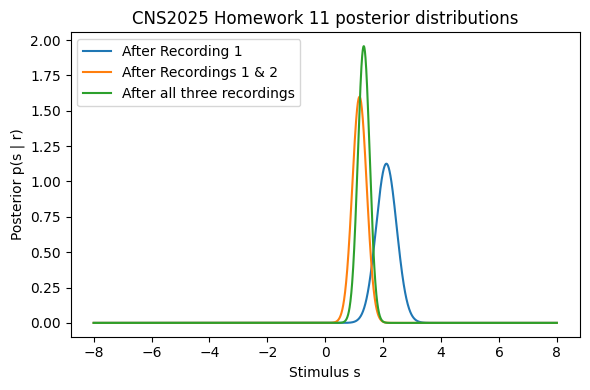

In [4]:
# @title
plt.figure(figsize=(6, 4))
plt.plot(s_grid, post1, label="After Recording 1")
plt.plot(s_grid, post12, label="After Recordings 1 & 2")
plt.plot(s_grid, post123, label="After all three recordings")
plt.xlabel("Stimulus s")
plt.ylabel("Posterior p(s | r)")
plt.title("CNS2025 Homework 11 posterior distributions")
plt.legend()
plt.tight_layout()
plt.show()
